In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation


In [2]:
data_df = pd.read_csv("diabetes.csv")

In [3]:
data_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
X ,y = data_df.drop('Outcome',axis=1), data_df['Outcome']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

In [8]:
input_layer = Input(shape=(8,))
x = Dense(32)(input_layer)
x = Activation('relu')(x)
output_layer = Dense(1,activation='sigmoid')(x)

base_model = Model(inputs=input_layer,outputs=output_layer)
base_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
base_model_hist = base_model.fit(X_train,y_train,epochs=50,batch_size=256,validation_data=(X_test,y_test))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5961 - loss: 0.6784 - val_accuracy: 0.5714 - val_loss: 0.7094
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6140 - loss: 0.6657 - val_accuracy: 0.5844 - val_loss: 0.6959
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6270 - loss: 0.6536 - val_accuracy: 0.6299 - val_loss: 0.6834
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6498 - loss: 0.6420 - val_accuracy: 0.6234 - val_loss: 0.6718
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6629 - loss: 0.6317 - val_accuracy: 0.6494 - val_loss: 0.6608
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6678 - loss: 0.6217 - val_accuracy: 0.6558 - val_loss: 0.6505
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6840 - loss: 0.6126 - val_accuracy: 0.6753 - val_loss: 0.6409
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6889 - loss: 0.6040 - val_accuracy: 0.6948 - val_loss: 0.6321


In [13]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

# 1. Create model-building function
def build_model(hp):

    model = keras.Sequential()

    # Tune number of hidden layers
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(layers.Dense(
            units = hp.Int(f"units_{i}", min_value=16, max_value=256, step=16),
            activation = hp.Choice("activation", ["relu", "tanh"])
        ))

    model.add(layers.Dense(1, activation="sigmoid"))

    # Tune learning rate for Adam
    lr = hp.Choice("learning_rate", [1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


# 2. Select tuner (RandomSearch / Hyperband / BayesianOptimization)
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,      # how many hp combinations
    executions_per_trial=1,
    directory="my_dir",
    project_name="demo_tuner"
)

Reloading Tuner from my_dir\demo_tuner\tuner0.json


In [14]:
# 3. Search best hyperparameters
tuner.search(X_train, y_train,
             epochs=5,
             validation_split=0.2)

In [15]:
# 4. Get best model and best hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters:
{'num_layers': 1, 'units_0': 192, 'activation': 'tanh', 'learning_rate': 0.001, 'units_1': 144, 'units_2': 240, 'units_3': 224}


c:\Users\adhab\OneDrive\Desktop\VsCode\DataScience\Deep Learning\deeplen\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
best_model_hist = best_model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/100


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7883 - loss: 0.4473 - val_accuracy: 0.7468 - val_loss: 0.5064
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7915 - loss: 0.4472 - val_accuracy: 0.7468 - val_loss: 0.5080
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7915 - loss: 0.4470 - val_accuracy: 0.7468 - val_loss: 0.5082
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7915 - loss: 0.4467 - val_accuracy: 0.7468 - val_loss: 0.5065
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7932 - loss: 0.4470 - val_accuracy: 0.7662 - val_loss: 0.5054
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7915 - loss: 0.4463 - val_accuracy: 0.7662 - val_loss: 0.5049
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7932 - loss: 0.4460 - val_accuracy: 0.7662 - val_loss: 0.5047
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7866 - loss: 0.4460 - val_accuracy: 0.7532 - val_loss: 0.5051
Epoc

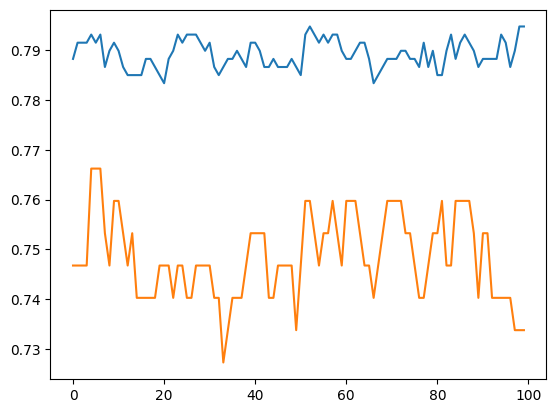

In [18]:
plt.plot(best_model_hist.history['accuracy'], label='Train Accuracy')
plt.plot(best_model_hist.history['val_accuracy'], label='Test Accuracy')

In [19]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):

    model = keras.Sequential()

    # -------------------------------
    # 1. TUNE INPUT LAYER NEURONS
    # -------------------------------
    input_neurons = hp.Int("input_neurons", min_value=16, max_value=256, step=16)
    model.add(layers.Dense(input_neurons, 
                           activation=hp.Choice("input_activation", ["relu", "tanh", "selu", "gelu"]),
                           input_shape=(X_train.shape[1],)))

    # Optional BatchNorm after input layer
    if hp.Boolean("input_batchnorm"):
        model.add(layers.BatchNormalization())

    # Optional Dropout after input layer
    model.add(layers.Dropout(hp.Float("input_dropout", 0.0, 0.5, step=0.1)))

    # -------------------------------
    # 2. TUNE HIDDEN LAYERS
    # -------------------------------
    num_layers = hp.Int("num_hidden_layers", 1, 5)

    for i in range(num_layers):

        # neurons per layer
        units = hp.Int(f"units_{i}", min_value=16, max_value=512, step=16)

        # activation function
        activation = hp.Choice(f"activation_{i}", ["relu", "tanh", "selu", "gelu"])

        model.add(layers.Dense(units, activation=activation))

        # BatchNorm decision
        if hp.Boolean(f"batchnorm_{i}"):
            model.add(layers.BatchNormalization())

        # Dropout layer
        dropout_rate = hp.Float(f"dropout_{i}", 0.0, 0.6, step=0.1)
        model.add(layers.Dropout(dropout_rate))

    # -------------------------------
    # 3. OUTPUT LAYER
    # -------------------------------
    model.add(layers.Dense(1, activation="sigmoid"))

    # -------------------------------
    # 4. TUNE OPTIMIZER + LEARNING RATE
    # -------------------------------
    lr = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")

    optimizer_name = hp.Choice("optimizer", ["adam", "sgd", "rmsprop", "nadam"])

    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(lr)
    elif optimizer_name == "sgd":
        optimizer = keras.optimizers.SGD(lr, momentum=hp.Float("sgd_momentum", 0.0, 0.9, step=0.1))
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop(lr)
    else:
        optimizer = keras.optimizers.Nadam(lr)

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model


In [20]:
# -------------------------------
# 5. TUNER SETTINGS
# -------------------------------
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=30,
    factor=3,
    directory="tuner_dir",
    project_name="advanced_tuner"
)

c:\Users\adhab\OneDrive\Desktop\VsCode\DataScience\Deep Learning\deeplen\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# -------------------------------
# 6. EARLY STOPPING DURING SEARCH
# -------------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [22]:
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop]
)

Trial 90 Complete [00h 00m 10s]
val_accuracy: 0.5609756112098694

Best val_accuracy So Far: 0.7886179089546204
Total elapsed time: 00h 06m 11s


In [25]:
# -------------------------------
# 7. GET BEST MODEL
# -------------------------------
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\nBest Hyperparameters:")
print(best_hp.values)


Best Hyperparameters:
{'input_neurons': 192, 'input_activation': 'gelu', 'input_batchnorm': False, 'input_dropout': 0.1, 'num_hidden_layers': 1, 'units_0': 368, 'activation_0': 'gelu', 'batchnorm_0': False, 'dropout_0': 0.1, 'learning_rate': 0.004535404569699291, 'optimizer': 'rmsprop', 'units_1': 416, 'activation_1': 'relu', 'batchnorm_1': False, 'dropout_1': 0.2, 'units_2': 400, 'activation_2': 'relu', 'batchnorm_2': True, 'dropout_2': 0.2, 'units_3': 464, 'activation_3': 'gelu', 'batchnorm_3': False, 'dropout_3': 0.0, 'units_4': 192, 'activation_4': 'tanh', 'batchnorm_4': True, 'dropout_4': 0.2, 'sgd_momentum': 0.30000000000000004, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0047'}


c:\Users\adhab\OneDrive\Desktop\VsCode\DataScience\Deep Learning\deeplen\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\adhab\OneDrive\Desktop\VsCode\DataScience\Deep Learning\deeplen\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
X_train.shape

(614, 8)

In [ ]:
best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8013 - loss: 0.4119 - val_accuracy: 0.7662 - val_loss: 0.6302
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8160 - loss: 0.4009 - val_accuracy: 0.7273 - val_loss: 0.6960
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8274 - loss: 0.3832 - val_accuracy: 0.7078 - val_loss: 0.6597
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8257 - loss: 0.3855 - val_accuracy: 0.7727 - val_loss: 0.6062
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8306 - loss: 0.3795 - val_accuracy: 0.7532 - val_loss: 0.6058
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8339 - loss: 0.3794 - val_accuracy: 0.7403 - val_loss: 0.6561
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8502 - loss: 0.3628 - val_accuracy: 0.7792 - val_loss: 0.6648
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8274 - loss: 0.3601 - val_accuracy: 0.7273 - val_loss: 0.7

: 